NNDL_Assignment_Roshan_230201927

Importing libraries 

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import functional as F
import torch.nn.init as init

connecting to GPU in available 

In [3]:
# Check CUDA device name
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


NVIDIA A100 80GB PCIe


Data Augmentation 

In [4]:
# Define transformations and load the dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.2154, 0.229))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.2154, 0.229))
])

Loading the CIFAR-10 Dataset

In [5]:
# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders for training and testing sets
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Defining the Architecture of the model

In [6]:
# # Define IntermediateBlock according to the given structure
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, num_conv_layers):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1) for _ in range(num_conv_layers)])
        self.batch_norms = nn.ModuleList([nn.BatchNorm2d(in_channels) for _ in range(num_conv_layers)])
        self.fc = nn.Linear(in_channels, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv_outputs = []
        for conv, bn in zip(self.conv_layers, self.batch_norms):
            out = conv(x)
            out = bn(out)
            out = F.relu(out)
            conv_outputs.append(out)

        # Combine convolutional layer outputs
        combined_output = torch.stack(conv_outputs, dim=0).sum(dim=0)  # Sum along the stack dimension

        # Compute the average value of each channel using the original input x
        avg_pool = F.avg_pool2d(x, x.size()[2:]).squeeze()

        # Compute learnable parameters using a fully connected layer
        a = self.fc(avg_pool)
        a = self.sigmoid(a)
        
        # Multiply each channel by its corresponding learnable parameter
        out = combined_output * a.unsqueeze(-1).unsqueeze(-1)

       
        return out


# Define OutputBlock according to the given structure
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        out = self.avg_pool(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Define ImprovedArchitecture
class ImprovedArchitecture(nn.Module):
    def __init__(self, num_blocks, num_conv_layers_per_block, num_classes=10):
        super(ImprovedArchitecture, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.blocks = nn.ModuleList([
            IntermediateBlock(128, num_conv_layers_per_block) for _ in range(num_blocks)
        ])
        self.output_block = OutputBlock(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        for block in self.blocks:
            x = block(x)
        x = self.output_block(x)
        return x


define the initialization

In [7]:
# Function to initialize weights using Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight.data)

In [8]:
# Function to train the model
def train(model, train_loader, test_loader, optimizer, criterion, scheduler, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_train = 0
        total_train = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Print training statistics
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], Train Loss: {loss.item():.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%')

        train_losses.append(total_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the test set
        test_accuracy = test(model, test_loader, device)

        # Step the scheduler
        scheduler.step(test_accuracy)

        # Save the model if it achieved the best test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

        test_accuracies.append(test_accuracy)

    return train_losses, train_accuracies, test_accuracies

# Function to test the model
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


define model

In [9]:
# Initialize the model, loss function, optimizer, and learning rate scheduler
model = ImprovedArchitecture(num_blocks=3, num_conv_layers_per_block=2).to(device)
model.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

In [10]:
# Train the model for 40 epochs
num_epochs = 40
train_losses, train_accuracies, test_accuracies = train(model, train_loader, test_loader, optimizer, criterion, scheduler, device, num_epochs)


Epoch [1/40], Step [100/391], Train Loss: 1.4728, Train Accuracy: 35.00%
Epoch [1/40], Step [200/391], Train Loss: 1.6542, Train Accuracy: 41.03%
Epoch [1/40], Step [300/391], Train Loss: 1.2718, Train Accuracy: 45.45%
Epoch [1/40], Train Accuracy: 48.44%, Test Accuracy: 53.65%
Epoch [2/40], Step [100/391], Train Loss: 1.2978, Train Accuracy: 61.01%
Epoch [2/40], Step [200/391], Train Loss: 0.9241, Train Accuracy: 62.21%
Epoch [2/40], Step [300/391], Train Loss: 0.8985, Train Accuracy: 63.46%
Epoch [2/40], Train Accuracy: 64.52%, Test Accuracy: 66.27%
Epoch [3/40], Step [100/391], Train Loss: 0.7173, Train Accuracy: 70.02%
Epoch [3/40], Step [200/391], Train Loss: 0.9472, Train Accuracy: 69.88%
Epoch [3/40], Step [300/391], Train Loss: 0.9317, Train Accuracy: 70.41%
Epoch [3/40], Train Accuracy: 70.57%, Test Accuracy: 69.61%
Epoch [4/40], Step [100/391], Train Loss: 0.7374, Train Accuracy: 73.20%
Epoch [4/40], Step [200/391], Train Loss: 0.6964, Train Accuracy: 73.57%
Epoch [4/40], Ste

plotting the accuracies 

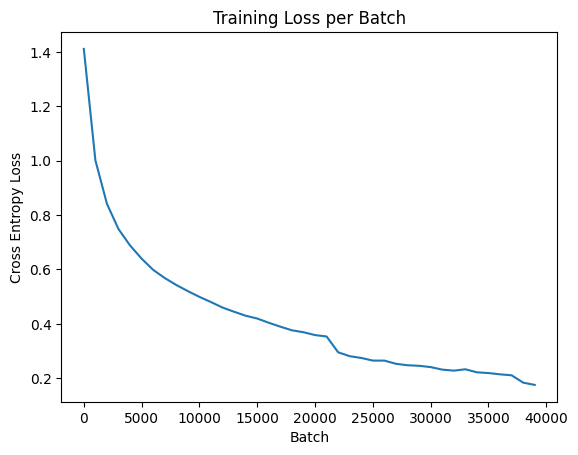

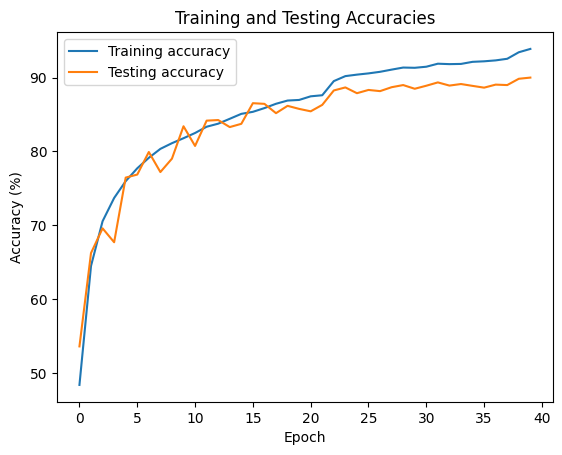

In [18]:
# Define the batch numbers
batch_numbers = [i * 1000 for i in range(len(train_losses))]

# Plot the loss for each batch
plt.plot(batch_numbers, train_losses)
plt.xlabel('Batch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss per Batch')
plt.show()
# Plots the training and testing accuracies
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(test_accuracies, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.show()
